# Advanced Lane Finding Project Pipeline

## Imports

In [34]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

import os
import glob
import pickle

from moviepy.editor import VideoFileClip

%matplotlib inline

## Camera Calbiration

`extract_points()` is responsible for generating the camera calibration matrix and distortion coefficients using the chessboard calibration images, while `camera_cal()` undistorts a given image (not used later on because only the matrix and dist coefficients are required, but its use is shown here for demonstration purposes).

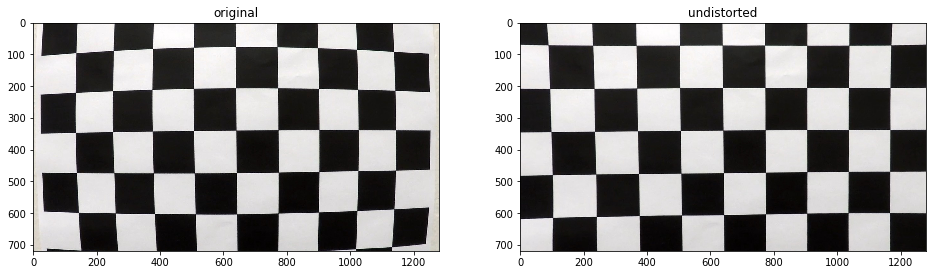

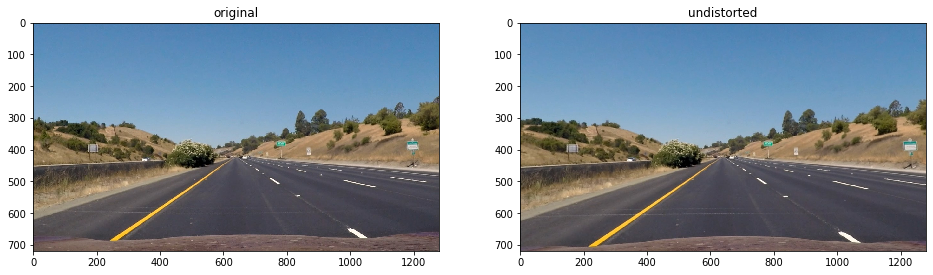

In [35]:
def extract_points(images):
    '''
    args:
        - images: list of strings containing the filenames of the calibration image set

    returns:
        - mtx: camera calibration matrix
        - dist: distortion coefficients
    '''

    obj = np.zeros((6 * 9, 3), np.float32)
    obj[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    obj_points = []
    img_points = []

    for filename in images:

        image = cv2.imread(filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret:
            obj_points.append(obj)
            img_points.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist

    pickle.dump(dist_pickle, open("dist_pickle.p", "wb"))

    return mtx, dist

def camera_cal(filename, mtx, dist):
    '''
    args:
        - filename: filename corresponding to a calibration image
        - mtx: camera calibration matrix (can be re-calculated using extract_points())
        - dist: distortion coefficients (can also be re-calculated using extract_points())

    returns:
        - ret: bool
        - mtx: camera matrix
        - dist: distortion coefficients
        - rvecs: rotation vectors
        - tvecs: translation vectors
    '''

    split = filename.split('.')

    new_filename = filename.split('.')[-2].split('/')[-1]

    image = mpimg.imread(filename)

    # undistort image
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    # write to new image for checking purposes
    plt.imsave("../undistorted/{}_undist.{}".format(new_filename, split[-1]), dst)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
    ax1.imshow(image)
    ax1.set_title("original")
    ax2.imshow(dst)
    ax2.set_title("undistorted")

    return dst

image_list = glob.glob("../camera_cal/*")

# this is only executed to generate new mtx and dist
#mtx, dist = extract_points(image_list)

# instead read saved mtx and dist from pickle file
dist_pickle = pickle.load(open("dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# test on a chessboard image
test_undist = camera_cal("../camera_cal/calibration1.jpg", mtx, dist)

# test on road images
road_undist = camera_cal("../test_images/straight_lines1.jpg", mtx, dist)

NOTE: `extract_points()` was only used to generate the matrix and distortion coefficients; for future runs, the saved mtx and dist are pulled from the pickle file.

## Gradient and Color Thresholding

At this point, the undistorted images will be prepared for lane detection. With a combination of color and gradient thresholding, pixels least likely to be relevant are hidden. I found that also adding a region of interest mask after this helped eliminate stray pixels that may be mistaken for lane lines later in the pipeline (occurred when one of the lines fails to be detected).

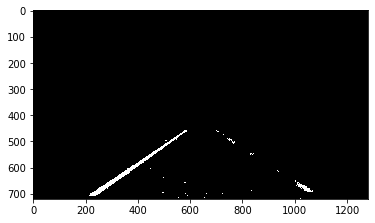

In [45]:
def threshold(image):
    # convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    s_channel = hls[:, :, 2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255 * abs_sobel_x / np.max(abs_sobel_x))

    sobelx_binary = np.zeros_like(scaled_sobel)
    sobelx_binary[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 100) & (s_channel <= 255)] = 1

    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(s_binary == 1) | (sobelx_binary == 1)] = 1

    # generate region of interest mask
    vertices = np.array([[(0, combined_binary.shape[0]), (550, 456), (730, 456), (combined_binary.shape[1], combined_binary.shape[0])]], dtype = np.int32)
    mask = np.zeros_like(combined_binary)

    if len(combined_binary.shape) > 2:
        ignore_mask_color = (255,) * combined_binary.shape[2]
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_combined_binary = cv2.bitwise_and(combined_binary, mask)

    return masked_combined_binary

# test on undistorted road image
thresholded = threshold(mpimg.imread("../undistorted/straight_lines1_undist.jpg"))
plt.imsave("../output_images/thresholded.jpg", thresholded, cmap = "gray")
plt.imshow(thresholded, cmap = "gray")

## Warping with Perspective Transform

The thresholded image is now warped using the same camera matrix and distortion coefficients calculated earlier, so as to provide a birds-eye view of the road. The source and destination points of the warp are hand-crafted and picked from the first straight line road sample image.

Text(0.5, 1.0, 'perspective transformed')

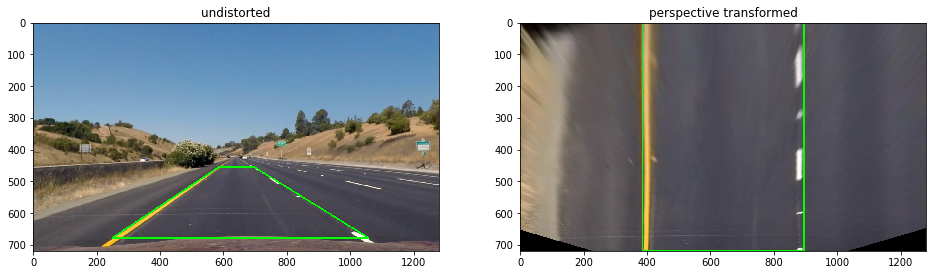

In [46]:
def perspective_transform(image, mtx, dist, src, dest):
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR)

    return warped

# hand-picked src and destination points
# src corresponds to a trapezoidal region in the original image
# dest corresponds to a rectangular region denoting the desired configuration/position of the src region after warping
src = np.float32([
    [250, 678], # bottom left
    [585, 456], # top left
    [698, 456], # top right
    [1057, 678] # bottom right
])

dest = np.float32([
    [386, 719], # bottom left
    [386, 0],   # top left
    [894, 0],   # top right
    [894, 719]  # bottom right
])

# auxiliary function for drawing diagram lines
def draw_lines(image, polygon):

    for i in range(len(polygon)):

        cv2.line(image, tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)]), (0, 255, 0), thickness = 3)

# test perspective transform function on thresholded image from before
warped = perspective_transform(road_undist, mtx, dist, src, dest)

# draw src and dest lines
undist_copy = np.copy(road_undist)
warped_copy = np.copy(warped)

draw_lines(undist_copy, src)
draw_lines(warped_copy, dest)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
ax1.imshow(undist_copy)
ax1.set_title("undistorted")

ax2.imshow(warped_copy)
ax2.set_title("perspective transformed")

## Lane Line Detection

Before detecting the pixels belonging to lane lines, I'll be using the Line class provided with some small modifications.

In [60]:
class Line():

    def __init__(self):

        # whether the line was detected in the previous frame
        self.detected = False

        # x vals of the last n fits of the line
        self.recent_xfitted = []

        # avg x vals from the last n fits
        self.bestx = None

        # polynomial coeffs avg'd from last n fits
        self.best_fit = None

        # polynomial coeffs from previous fit
        self.prev_fit = [np.array([False])]

        # x and y vals from the current and previous detections
        self.x = None
        self.y = None
        self.prev_x = None
        self.prev_y = None

        # x and y fits from current and previous poly. fit
        self.fit_x = None
        self.fit_y = None
        self.prev_fit_x = None
        self.prev_fit_y = None

        # polynomial coeffs of current fit
        self.current_fit = [np.array([False])]

        # radius of curvature of the line
        self.radius_of_curvature = None

        # line position in image (not the distance from line to car as suggested; this will later be calculated using the base pos of L+R lane lines)
        self.line_base_pos = None

        # diff between prev and current line of best fit coefficients
        self.diffs = np.array([0, 0, 0], dtype = 'float')

At this phase, we're ready to perform basic lane line detection. Initially, I started with only the sliding windows method, in which activated pixels in a binary image (each in their respective search window) define the area of search as we progress from the bottom of the image (where the base of the lane line is detected) to the top. The pixels found are later used to fit a polynomial and obtain a much smoother line.

In [61]:
def sliding_window(image, left_lane_line, right_lane_line):
    histogram = np.sum(image[image.shape[0] // 2:, :], axis = 0)

    out_img = np.dstack((image, image, image))

    mid = np.int(histogram.shape[0] // 2)
    left_base = np.argmax(histogram[:mid])
    right_base = np.argmax(histogram[mid:]) + mid
    car_center = mid
    lane_center = (left_base + right_base) // 2

    # set up sliding window procedure
    num_windows = 9
    margin = 100
    min_pix = 50

    win_height = np.int(image.shape[0] // num_windows)

    # all activated pixels
    nonzero = image.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])

    left_current = left_base
    right_current = right_base

    left_lane_indices = []
    right_lane_indices = []

    for window in range(num_windows):
        leftx_start = left_current - margin
        rightx_start = right_current - margin
        leftx_end = left_current + margin
        rightx_end = right_current + margin

        y_start = image.shape[0] - (window + 1) * win_height
        y_end = image.shape[0] - window * win_height

        cv2.rectangle(out_img, (leftx_start, y_start), (leftx_end, y_end), (0, 255, 0), 2)
        cv2.rectangle(out_img, (rightx_start, y_start), (rightx_end, y_end), (0, 255, 0), 2)

        # extract nonzero pixels in windows
        left_inds = ((nonzero_y >= y_start) & (nonzero_y < y_end) & (nonzero_x >= leftx_start) & (nonzero_x < leftx_end)).nonzero()[0]
        right_inds = ((nonzero_y >= y_start) & (nonzero_y < y_end) & (nonzero_x >= rightx_start) & (nonzero_x < rightx_end)).nonzero()[0]

        left_lane_indices.append(left_inds)
        right_lane_indices.append(right_inds)

        if len(left_inds) > min_pix:
            left_current = np.int(np.mean(nonzero_x[left_inds]))
        
        if len(right_inds) > min_pix:
            right_current = np.int(np.mean(nonzero_x[right_inds]))

    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices]
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]

    left_lane_line.detected = True
    right_lane_line.detected = True

    left_lane_line.prev_x = left_lane_line.x
    left_lane_line.x =  left_x

    right_lane_line.prev_x = right_lane_line.x
    right_lane_line.x = right_x

    left_lane_line, right_lane_line, out_img = fit_poly(image.shape, left_lane_line, right_lane_line, out_img)

    return left_x, left_y, right_x, right_y, car_center, lane_center, out_img

# fit the detected lane pixels a polynomial
def fit_poly(img_shape, left_lane_line, right_lane_line, out_img):

    left_fit = np.polyfit(lefty, leftx, deg = 2)
    right_fit = np.polyfit(righty, rightx, deg = 2)

    y = np.linspace(0, img_shape[0] - 1, img_shape[0])

    left_fitx = left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2]
    right_fitx = right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2]

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    left_lane_line.prev_fit = left_lane_line.current_fit
    left_lane_line.current_fit = left_fit

    right_lane_line.prev_fit = right_lane_line.current_fit
    right_lane_line.current_fit = right_fit

    return left_fit, right_fit, left_fitx, right_fitx, y, out_img

# testing the sliding window method
# line objects
left_lane_line = Line()
right_lane_line = Line()

# get warped binary image from thresholding step
warped = perspective_transform(thresholded, mtx, dist, src, dest)

leftx, lefty, rightx, righty, car_center, lane_center, out_img = sliding_window(warped, left_lane_line, right_lane_line)

# after fitting to polynomial
left_fit, right_fit, left_fitx, right_fitx, y, out_img = fit_poly(warped.shape, leftx, lefty, rightx, righty, out_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

ax1.imshow(warped, cmap = "gray")
ax1.set_title("warped")

ax2.imshow(out_img, cmap = "gray")
ax2.plot(left_fitx, y, color = "yellow")
ax2.plot(right_fitx, y, color = "yellow")
ax2.set_title("detected + fit to poly")

ValueError: too many values to unpack (expected 3)

### Searching from prior frames

If we've detected a lane line in the previous frame(s), there's no need to start from scratch since the positions of lane lines change very little from frame to frame. So, instead, search in a region around the previous lane lines for activated pixels.

In [ ]:
def prior_frame_search(warped, margin = 100, left_fit, right_fit):

    nonzero = warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    poly_left = nonzeroy ** 2 * left_fit[0] + nonzeroy * left_fit[1] + left_fit[2]
    poly_right = nonzeroy ** 2 * right_fit[0] + nonzeroy * right_fit[1] + right_fit[2]

    left_lane_inds = ( (nonzerox >= poly_left - margin) & (nonzerox < poly_left + margin) )
    right_lane_inds = ( (nonzerox >= poly_right - margin) & (nonzerox < poly_right + margin) )

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty